In [172]:
import torch
from src.spaces.hyperbolic import HyperbolicSpace
from src.spectral_kernel import RandomFourierFeaturesKernel
from src.prior_approximation import RandomFourierApproximation
from src.spectral_measure import MaternSpectralMeasure, SqExpSpectralMeasure
import matplotlib.pyplot as plt

In [173]:
order = 10**4
space = HyperbolicSpace(n=2, order=order)

In [174]:
lengthscale, nu = 0.1, 5.0 + space.dim
measure = SqExpSpectralMeasure(space.dim, lengthscale)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

In [175]:
kernel = RandomFourierFeaturesKernel(measure, space)
sampler = RandomFourierApproximation(kernel)

In [176]:
def disk_to_hyperboloid(x):
    x_sq_norm = torch.sum(x * x, dim=1)
    t = ((x_sq_norm + 1)/(1-x_sq_norm))
    y = x * (1 + t)[:, None]
    return torch.cat((t.view(-1,1), y), dim=1)

def hyperboloid_to_disk(y):
    x = y[:, 1:]/((1+y[:,0])[:, None])
    return x

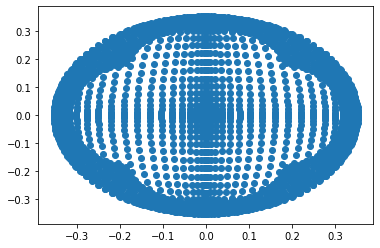

In [177]:
lspace = torch.linspace(-1.5, 1.5, 50)
lspace = torch.sign(lspace) * torch.square(torch.abs(lspace))
y = torch.cartesian_prod(lspace, lspace)
y_sq_norm = torch.sum(y * y, dim=1)
y = torch.cat((1+y_sq_norm.view(-1,1), y), dim=1)
x = hyperboloid_to_disk(y)
plt.scatter(x.numpy()[:,0], x.numpy()[:,1])
plt.show()

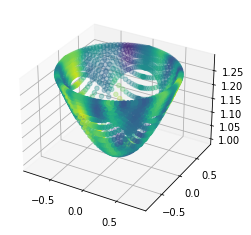

In [178]:
samples=sampler(x)
y = disk_to_hyperboloid(x)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(y[:, 1], y[:, 2], y[:,0], c=samples)
plt.show()